In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sys
sys.version
sys.version_info

'3.7.0 (default, Jun 28 2018, 13:15:42) \n[GCC 7.2.0]'

sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)

In [4]:
#export
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp

from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from PIL import Image

# CIFAR subset data

First we want to view our data to check if everything is how we expect it to be.

## Setup

In [5]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

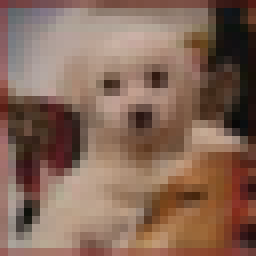

In [6]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

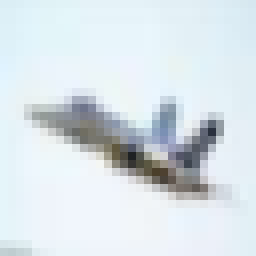

In [7]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

We will build a Dataset class for our image files. A Dataset class needs to have two functions: length and get-item. Our FilesDataset additionally gets the image files from their respective directories and transforms them to tensors.

In [6]:
list((TRAIN_PATH).iterdir())
list((TRAIN_PATH).iterdir())[0].is_dir()

[PosixPath('data/cifar10_dog_air/train/dog'),
 PosixPath('data/cifar10_dog_air/train/airplane')]

True

In [6]:
#export
def find_classes(folder):
    # return class list
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    # get all image file name from class
    return [o for o in c.iterdir()
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1) # height x width x channels
    arr = arr.permute(2,0,1) # channels x height x width
    return arr.float().div_(255) # normalize between 0 and 1

In [7]:
#export
class FilesDataset(Dataset):
    def __init__(self, folder, classes=None):
        # var: X:filenames,y:class (number), class (name)
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [8]:
train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test')

In [12]:
train_ds.classes

['airplane', 'dog']

In [13]:
x = PIL.Image.open(train_ds.fns[0]).convert('RGB')

In [14]:
x
type(x)
x.size

print('convert to bytes -> tensor')

temp=torch.ByteStorage(x.tobytes())
temp.size()
temp2=torch.ByteTensor(temp).view(x.size[1],x.size[0],-1)

convert to bytes -> tensor


In [15]:
temp2.size()

torch.Size([32, 32, 3])

In [16]:
train_ds.fns[:5]
train_ds.y[:5]

[0, 0, 0, 0, 0]

In [17]:
train_ds[0][0].size()

torch.Size([3, 32, 32])

In [18]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [9]:
#export
def image2np(image): 
    # convert float tensor (between 0 and 1) back to normal picture (0 to 255, height x width x channels)
    return image.cpu().permute(1,2,0).numpy()

In [20]:
x,y = train_ds[0]
x.type()
x.size()
x

tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

airplane


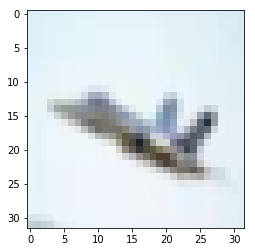

In [21]:
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [11]:
bs=64

In [23]:
??DataBunch

In [12]:
data = DataBunch(train_ds, valid_ds, bs=bs) # no transformation yet
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [10]:
#export
def show_image(img, ax=None, figsize=(3,3), hide_axis=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    if hide_axis: ax.axis('off')

def show_image_batch(dl, classes, rows=None, figsize=(12,15)):
    # show row x row image matrix with class label
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x,y,rows, classes, figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

In [15]:
default_device

device(type='cuda', index=0)

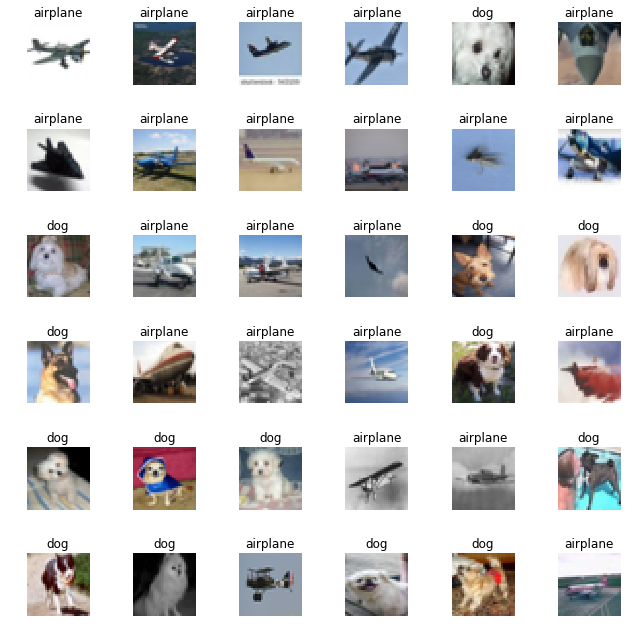

In [16]:
show_image_batch(data.train_dl, train_ds.classes, rows=6)

# Data augmentation

Now we are going augment our data to increase our training set. We will start by changing the brightness and contrast of our images.

Brightness is computed by taking the logit of the change and adding it to the logit of the images pixels. Finally we take the sigmoid of the result.

Contrast is computed by simply multiplying pixel values by the scale.

## Lighting

We will start by changing the brightness and contrast of our images.

## Method
### Brightness

Brightness refers to where does our image stand on the dark-light spectrum. Brightness is applied by adding a positive constant to each of the image's channels. This works because each of the channels in an image goes from 0 (darkest) to 255 (brightest) in a dark-light continum. (0, 0, 0) is black (total abscence of light) and (255, 255, 255) is white (pure light). You can check how this works by experimenting by yourself here.

Parameters

Change How much brightness do we want to add to (or take from) the image.

$C \in \mathbb{R}$

### Contrast

Contrast refers to how sharp a distinction there is between birghter and darker sections of our image. To increase contrast we need darker pixels to be darker and lighter pixels to be lighter. In other words, we would like channels with a value smaller than 128 to decrease and channels with a value of greater than 128 to increase.

Parameters

Scale How much contrast do we want to add to (or remove from) the image.

$C \in [0, inf]$

### On logit and sigmoid

Notice that for both transformations we first apply the logit to our tensor (convert x: 0 to 1 to x: -inf to inf), then apply the transformation (add constant to x for brightness or multiply constant to xfor contrast) and finally take the sigmoid (back to x: 0 and 1). This is important for two reasons.

First, we don't want to overflow our tensor values. In other words, we need our final tensor values to be $T_{ij} \in [0,1]$. Imagine, for instance, a tensor value at 0.99. We want to increase its brightness, but we can’t go over 1.0. By doing logit first, which first moves our space to $-inf$ to $+inf$, this works fine. The same applies to contrast if we have a scale S >1 (might make some of our tensor values greater than one).

Second, when we apply contrast, we need to affect the dispersion (state of being spread over an area) of values around the middle value. Say we want to increase contrast. Then we need the bright values (>0.5) to get brighter and dark values (<0.5) to get darker. We must first transform our tensor values so our values which were originally <0.5 are now negative and our values which were originally >0.5 are positive. This way, when we multiply by a constant, the dispersion around 0 will increase (small numbers around 0 * positive scale = small numbers => they don't change much?). The logit function does exactly this and allows us to increase or decrease dispersion around a mid value.

In [28]:
??partial

# return a new function with fewer parameters and fixed values set for the original function

In [17]:
def multiply(x,y,z):
        return 3*x + 2*y + z
func1 = partial(multiply,3)
print(func1(2,1))

func2 = partial(multiply,3,2)
print(func2(1))

14
14


In [13]:
#export
# def logit(x):  return -(1/x-1).log()
def logit_(x): return (x.reciprocal_().sub_(1)).log_().neg_() # -log(1/x -1)

def brightness(x, change): 
    # the change to be added to x for brightness should be between 0 and 1, as it will be transformed using logit
    # so that they on the same scale when adding?
    return x.add_(scipy.special.logit(change))
def contrast(x, scale): return x.mul_(scale)

def _apply_lighting(x, func):
    if func is None: return x
    return func(logit_(x)).sigmoid()

def apply_lighting(func): 
    # a function which accept another (partial) function and return partial function (which accept that function input)
    return partial(_apply_lighting, func=func)

In [14]:
def apply_contrast(scale): return apply_lighting(partial(contrast, scale=scale))

In [16]:
x = lambda: train_ds[1][0]

# Don't use the following to test these transformation functions
# as these functions above are meant to be used to permanently transform tensor
# x = train_ds[1][0]. 
# x.size()
# x.type()

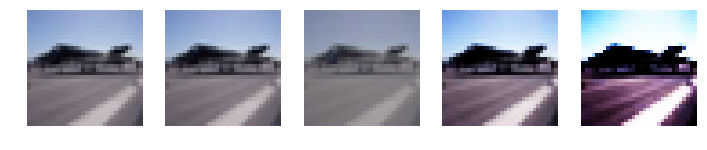

In [33]:
_,axes = plt.subplots(1,5, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_contrast(1.0)(x()), axes[1])
show_image(apply_contrast(0.5)(x()), axes[2])
show_image(apply_contrast(2.0)(x()), axes[3])
show_image(apply_contrast(5.0)(x()), axes[4])

In [15]:
def apply_brightness(change):
    return apply_lighting(partial(brightness, change=change))

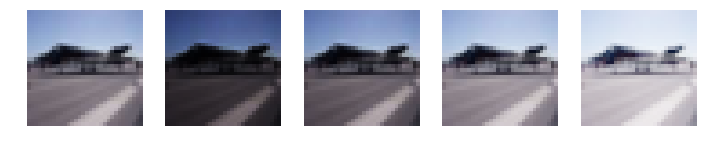

In [35]:
_,axes = plt.subplots(1,5, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_brightness(0.2)(x()), axes[1])
show_image(apply_brightness(0.4)(x()), axes[2])
show_image(apply_brightness(0.6)(x()), axes[3])
show_image(apply_brightness(0.8)(x()), axes[4])

In [17]:
#export
def listify(p=None, q=None):
    # duplicate single-item list p q times
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else (1 if q is None else len(q))
    if len(p)==1: p = p * n
    return p

def compose(funcs):
    # funcs is list of partial functions. Execute this list of functions in order
    # compose acts as a wrapper for multiple PARTIAL functions in funcs list
    def _inner(x, *args, **kwargs):
        for f in listify(funcs): x = f(x, *args, **kwargs)
        return x
    return _inner if funcs else None

In [114]:
listify((2),3)
listify(2,3)
listify([2,3],3)
listify((2,3))

[2, 2, 2]

[2, 2, 2]

[2, 3]

(2, 3)

In [50]:
sc = 0.5
cb = 0.5
compose([partial(contrast, scale=0.5),partial(brightness, change=0.5)])

<function __main__.compose.<locals>._inner(x, *args, **kwargs)>

```
def apply_lighting(func): 
    return partial(_apply_lighting, func=func)
    
def _apply_lighting(x, func):
    if func is None: return x
    
    # this is where compose will kick in. I.e of the actual call
    # _apply_lighting(x, compose) # partial
    # -> compose(logit_(x))
    # -> _inner(logit_(x), args and kwargs)
    # -> x = contrast(logit_(x),scale_contrast)
    # -> x = brightness(x,change_brightness)
    # -> return x.sigmoid()
    return func(logit_(x)).sigmoid() 
```

In [18]:
def apply_brightness_contrast(scale_contrast, change_brightness):
    # remember that apply_lighting return a partial function with func input
    combined_func = compose([partial(contrast, scale=scale_contrast),
                               partial(brightness, change=change_brightness)]
                             )
    return apply_lighting(combined_func)

In [19]:
# explaining compose function
def show_stuff(x,k1=42,k2='yolo'):
    print(x)
    print(k1)
    print(k2)
def wrap(func): # passing in a partial function
    def inner(*args,**kwargs): # since func remember its fixed parameter, 
        #its wrapper, inner, will also get these fixed parameters
        func(*args,**kwargs)        
    return inner

func3 = partial(show_stuff,k2='YOLO BIATCH') # func3 already remember its fixed parameter here
wrap(func3)(3)

3
42
YOLO BIATCH


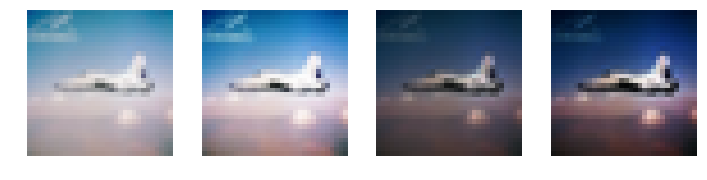

In [71]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(apply_brightness_contrast(0.75, 0.7)(x()), axes[0]) # less contrast,  brighter
show_image(apply_brightness_contrast(1.3,  0.7)(x()), axes[1]) # more contrast, brighter
show_image(apply_brightness_contrast(0.75, 0.3)(x()), axes[2]) # less contrast, dimmer
show_image(apply_brightness_contrast(1.3,  0.3)(x()), axes[3]) # more contrast, dimmer



## Random lighting

Next, we will make our previous transforms random since we are interested in automatizing the transforms pipeline. We will achieve this by making our parameters stochastic with a specific distribution: uniform for brightness and log_uniform for contrast.

We will use a *uniform* distribution for brightness change since its domain is the real numbers and the impact varies linearly with the scale. For contrast we use *log_uniform* for two reasons. First, contrast scale has a domain of [0, inf]. Second, the impact of the scale in the transformation is non-linear (i.e. 0.5 is as extreme as 2.0, 0.2 is as extreme as 5). The log_uniform function is appropriate because it has the same domain and correctly represents the non-linearity of the transform, P(0.5) = P(2).

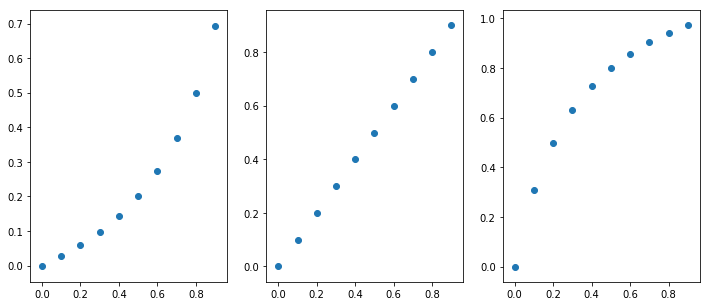

In [23]:
# brightness impact varies linearly with scale
def logit(x):  return scipy.special.logit(x)
def sigmoid(x): return 1 / (1+np.e**(-x))
fig,axes = plt.subplots(1,3,figsize=(12,5))
pixel=0.2
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[0].scatter(brightness,pixel_r)

pixel=0.5
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[1].scatter(brightness,pixel_r)

pixel=0.8
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[2].scatter(brightness,pixel_r)

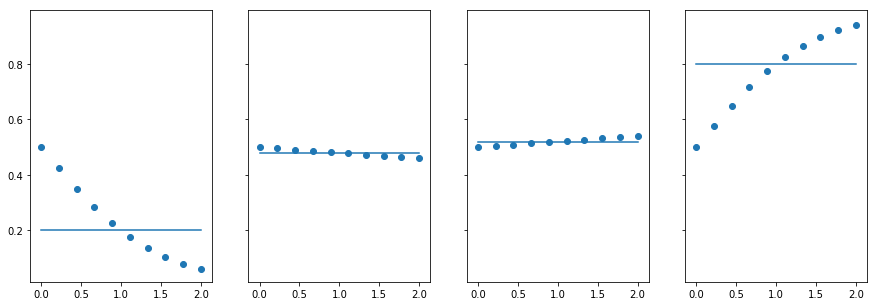

In [24]:
# contrast scales affect pixel differently

fig,axes = plt.subplots(1,4,figsize=(15,5),sharey=True)

pixel=0.2
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[0].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[0].scatter(contrast_scale,pixel_r)

pixel=0.48
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[1].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[1].scatter(contrast_scale,pixel_r)

pixel=0.52
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[2].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[2].scatter(contrast_scale,pixel_r)

pixel=0.8
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[3].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[3].scatter(contrast_scale,pixel_r)

In [20]:
#export
def uniform(low, high, size=None):
    return random.uniform(low,high) if size is None else torch.FloatTensor(size).uniform_(low,high)

def log_uniform(low, high, size=None):
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p, size=None): return uniform(0,1,size)<p


In [54]:
for i in TfmType:
    print(i)

TfmType.Start
TfmType.Affine
TfmType.Coord
TfmType.Pixel
TfmType.Lighting


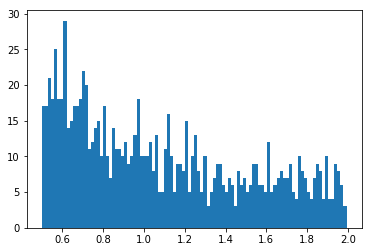

In [57]:
# log uniformdistribution
log_u = [log_uniform(0.5,2.0) for _ in range(1000)]
plt.hist(log_u,bins=100);

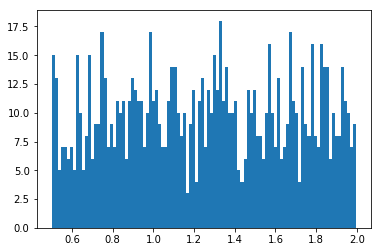

In [59]:
# standard uniform dist
u = [uniform(0.5,2.0) for _ in range(1000)]
plt.hist(u,bins=100);

In [61]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

1.0130243963571068

In [66]:
def func1(a,b,c:int,d='temp'):
    pass
get_default_args(func1)

{'d': 'temp'}

In [22]:
from IPython.core.debugger import set_trace

In [26]:
#export
import inspect
from copy import copy,deepcopy

def get_default_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

class Transform():
    def __init__(self, func, p=1., **kwargs):
#         set_trace()
        # func is the lowest-level tfm function, i.e contrast. Not partial. Input parameters: x (tensor) and a constant (scale)
        self.func,self.p,self.kw = func,p,kwargs #self.kw is a dict {tfm_param : (low,high)}, i,e {'scale':(0.3,5)}
        self.def_args = get_default_args(func) # get tfm default param in dic {tfm_param: constant}, i.e {'scale':1}
        self.params = copy(func.__annotations__)
        # i.e for contrast, self.params should be  {'scale': <func to get random scale from log distribution b/t low and high>}
        self.params.pop('return') 
    @property
    def name(self): return self.__class__.__name__ # a getter
    
    def __repr__(self):
        return f'{self.func.__name__}_tfm->{self.name}; {self.kw} (p={self.p})'

    def resolve(self):
        # either get a constant from random distribution or other use case?
        self.resolved = {}
        for k,v in self.params.items():
            if k not in self.kw and k in self.def_args: 
                # if there is a default param for tfm but it's not specified in self.kw
                # TODO: use case for this? Probably when user wants a specific scale for transformation
                self.resolved[k] = self.def_args[k]
            else: 
                # k in self.kw or k not in self.def_args
                # i.e, right hand side will be log_uniform(*(low,high))
                # self.resolved is {'scale': random constant between low and high}
                self.resolved[k] = v(*listify(self.kw[k]))
        self.do_run = rand_bool(self.p) # boolean, True or False

    def __call__(self, x, *args, **kwargs): # function call operator. Called when running tfm = Transform(...); tfm(...)
        #execute the lowest-level transform function on x
        #for contrast example, only kwargs are passed
        return self.func(x, *args, **self.resolved, **kwargs) if self.do_run else x
    
    def apply(self, tfms=None):
        if tfms is None: 
            # if there is no other tfm is passed, use self (the Transform class itself) as a function (__call__ wil be used)
            tfms=self
        # execute multiple low-level tfms using compose func. Return transformed x. resolve should be called first?
        return compose(tfms)

class TfmLighting(Transform):
    def apply(self, tfms=None): 
        # do the logit -> tfm func -> sigmoid for lighting
        return apply_lighting(super().apply(tfms))

In [137]:
??_apply_lighting

In [23]:
def brightness(x, change:uniform) -> TfmLighting:
    return x.add_(scipy.special.logit(change))

def contrast(x, scale:log_uniform) -> TfmLighting:
    return x.mul_(scale)

In [99]:
brightness.__annotations__
brightness.__annotations__.items()

{'change': <function __main__.uniform(low, high, size=None)>,
 'return': __main__.TfmLighting}

dict_items([('change', <function uniform at 0x000000001A875510>), ('return', <class '__main__.TfmLighting'>)])

In [29]:
x = lambda: train_ds[1][0]

In [32]:
contrast_tfm = partial(contrast.__annotations__['return'], contrast)
tfm = contrast_tfm(scale=(0.3,3))
tfm.resolve()
tfm
tfm.resolved

contrast_tfm->TfmLighting; {'scale': (0.3, 3)} (p=1.0)

{'scale': 1.749491030001559}

{'scale': 0.6856669270128438}

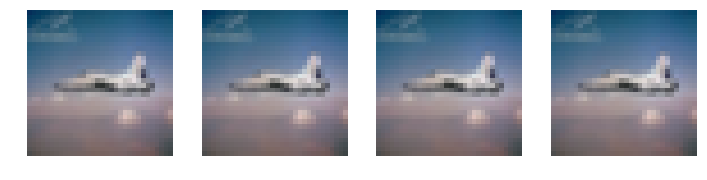

In [33]:
# all the same
tfm.resolve()
tfm.resolved
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(tfm.apply()(x()), ax)

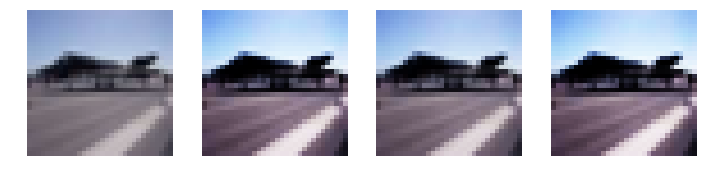

In [121]:
tfm = contrast_tfm(scale=(0.3,3), p=0.5)

# different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve() # whenever this is called, scale gets another random constant is drawed
    show_image(apply_lighting(tfm)(x()), ax)

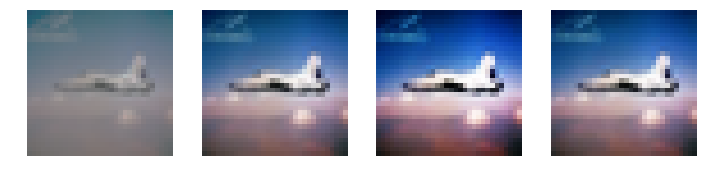

In [34]:
tfm = contrast_tfm(scale=(0.3,3), p=1)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    show_image(apply_lighting(tfm)(x()), ax)


## Decorator and composition

We are interested in composing the transform functions so as to apply them all at once. We will try to feed a list of transforms to our pipeline for it to apply all of them.

Applying a function to our transforms before calling them in Python is easiest if we use a decorator. You can find more about decorators here.

Function decorators: wrappers to existing functions, to add new functionality to existing functions

In [87]:
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)

def p_decorate(func):
    def func_wrapper(name):
        return "<p>{0}</p>".format(func(name))
    return func_wrapper

get_text = p_decorate(get_text)

print(get_text("John"))

<p>lorem ipsum, John dolor sit amet</p>


In [91]:
# using decorator:
def p_decorate(func):
    def func_wrapper(name):
        return "<p>{0}</p>".format(func(name))
    return func_wrapper

def div_decorate(func):
    def func_wrapper(name):
        return "<div>{0}</div>".format(func(name))
    return func_wrapper
@p_decorate
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)
@p_decorate
def get_another_text(name):
    return "YO, {0} IS DOPE".format(name)

print (get_text("John"))
print(get_another_text("John"))

@div_decorate
@p_decorate
def get_another_text2(name):
    return "YO, {0} IS DOPE".format(name)
print(get_another_text2('John'))

<p>lorem ipsum, John dolor sit amet</p>
<p>YO, John IS DOPE</p>
<div><p>YO, John IS DOPE</p></div>


**Continue from here**

In [123]:
contrast.__module__

'__main__'

In [24]:
#export
def reg_transform(func):
    tfm = partial(func.__annotations__['return'], func)
    
    # change partial function name func_tfm
    setattr(sys.modules[func.__module__], f'{func.__name__}_tfm', tfm)
    return func

@reg_transform
def brightness(x, change:uniform) ->TfmLighting: return x.add_(scipy.special.logit(change))

@reg_transform
def contrast(x, scale:log_uniform)->TfmLighting: return x.mul_(scale)



In [25]:
def resolve_tfms(tfms):
    for f in listify(tfms): f.resolve()

def _apply_tfms(x,tfms):
    if not tfms: return x
    resolve_tfms(tfms) #make sure to 'resolve' (draw a constant from uniform distribution)
#     for f in tfms:
#         print(f.resolved,f.do_run)

    # this is just odd... tfms[0], which is a TfmLighting CLASS, receive a list of other TfmLightingClass into its apply function
    return tfms[0].apply(tfms)(x.clone()) 
    

def apply_tfms(tfms): return partial(_apply_tfms, tfms=tfms)

In [175]:
??TfmLighting.apply

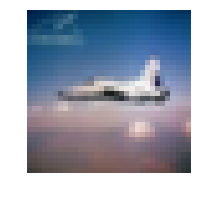

In [90]:
x = train_ds[1][0]
show_image(x)
#original

In [174]:
??Transform.apply

In [172]:
??_apply_tfms

{'scale': 0.5121735213889604} True
{'change': 0.4860031621506206} False
{'scale': 1.415747509162914} False
{'change': 0.5454761543557511} True
{'scale': 2.111201629710358} True
{'change': 0.5393430382163225} False
{'scale': 1.421424921538738} False
{'change': 0.35442093801055985} False


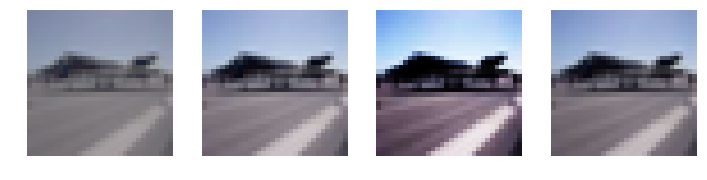

In [171]:
tfms = [contrast_tfm(scale=(0.3,3.0), p=0.5),
        brightness_tfm(change=(0.35,0.65), p=0.5)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)
# transform image x 4 times with p=1, independently

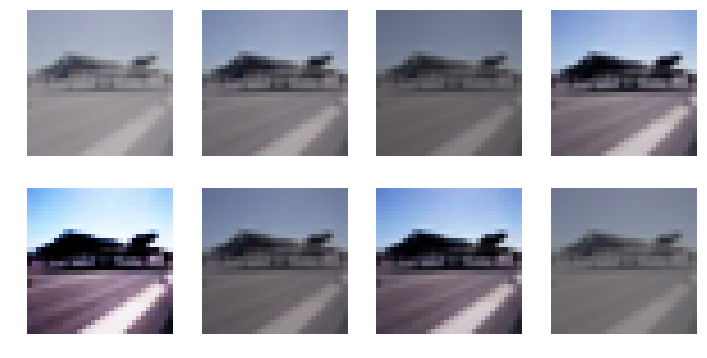

In [180]:
tfms = [contrast_tfm(scale=(0.3,3.0), p=1),
        brightness_tfm(change=(0.35,0.65), p=1)]

_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x), axes[0][i])
    show_image(tfm(x), axes[1][i])

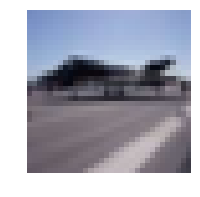

In [181]:
show_image(apply_tfms([])(x)) # no transformation

# Affine

## Deterministic affine

In [88]:
#export
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [87]:
#export
def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    '''
    Given an input and a flow-field grid, 
    computes the output using input pixel locations from the grid.
    '''
    if padding_mode=='reflect': padding_mode='reflection'
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(x, matrix, size=None):
    '''
    Generates a 2d flow field, given a batch of affine matrices theta.
    Generally used in conjunction with grid_sample() to implement Spatial Transformer Networks.
    '''
    if size is None: size = x.size()
    elif isinstance(size, int): size=(x.size(0), size, size)
    return F.affine_grid(matrix[None,:2,:], # 3x3 to N x 2 x 3 (N=1)
                         torch.Size((1,)+size)) # N x channel x h x w
    # return tensor of size N x h x w x 2

In [91]:
def rotate(degrees):
    angle = degrees * math.pi / 180 # to radian
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

In [89]:
torch.Size((1,)+x.size())

torch.Size([1, 3, 32, 32])

In [65]:
m = rotate(10)
m = x.new_tensor(m)
m.type()
m.shape

'torch.FloatTensor'

torch.Size([3, 3])

In [79]:
c = affine_grid(x, m)
c.size()

torch.Size([1, 32, 32, 2])

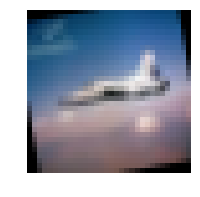

In [76]:
# c = affine_grid(x, m)
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

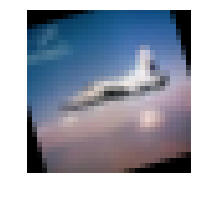

In [35]:
m = rotate(16)
m = x.new_tensor(m)
c = affine_grid(x, m)
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

In [92]:
#export
def affines_mat(img, matrices=None):
    matrices = [img.new_tensor(m) for m in matrices if m is not None]
    if not matrices: return None
    return reduce(torch.matmul, matrices, torch.eye(3))

def affine_mult(c,m):
    if m is None: return c
    size = c.size()
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t()) 
    return c.view(size)

def _apply_affine(c, size=None, mats=None, func=None, **kwargs):
    return affine_mult(c, affines_mat(c, mats))

def apply_affine(mats): return partial(_apply_affine, mats=mats)

def affine_only(x, mats, size=None, **kwargs):
    tfm = apply_affine(mats)
    c = affine_grid(x, torch.eye(3), size=size)
    c = tfm(c)
    return grid_sample(x, c, **kwargs)

In [93]:
img2 = affine_only(x, [rotate(30)])
show_image(img2)

ValueError: padding_mode needs to be 'zeros' or 'border', but got reflection

In [94]:
def zoom(scale: uniform, row_pct=0.5, col_pct=0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

In [96]:
show_image(affine_only(x, [zoom(0.6)]))

ValueError: padding_mode needs to be 'zeros' or 'border', but got reflection